In [142]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random

import datetime
from pprint import pprint

from ts.utility import Utility
from ts.experimental import GeneralizedExtremeValueDistribution, GevEstimate, Pso
from ts.decompose import StlDecompose

In [2]:
dal = pd.read_csv("datasets/dal_data_monthly_original.csv")
# Step 1: Format time column as datetime format
dal['time'] = pd.to_datetime(dal['time'])
dal.set_index('time', inplace = True)
dal

,DAL
time,
1946-07-31,0.0000
1946-08-31,2.3300
1946-09-30,1.3800
1946-10-31,0.6000
1946-11-30,4.3900
...,...
2022-08-31,9.0804
2022-09-30,0.9103
2022-10-31,1.8802


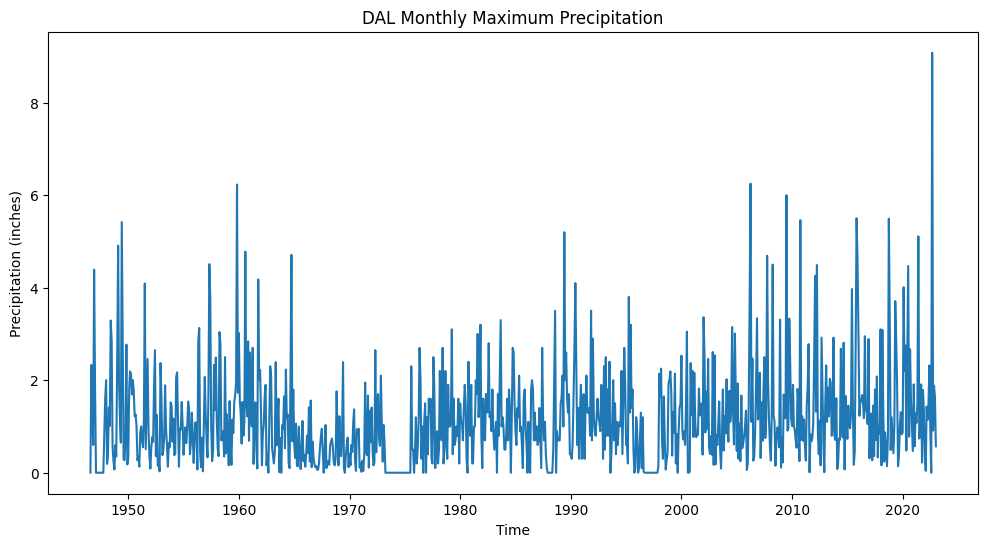

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(dal.index, dal.DAL)
plt.title('DAL Monthly Maximum Precipitation')
plt.xlabel('Time')
plt.ylabel('Precipitation (inches)')

# Save the figure at 300 DPI
plt.savefig("dal_monthly_max_precip.png", dpi=300, bbox_inches='tight')

plt.show()

In [6]:
month_max_series = dal.DAL
month_max_series.shape

(918,)

In [7]:
month_date_series = month_max_series.index # Probably can use the exact day insead of the last day of each month
month_date_series

DatetimeIndex(['1946-07-31', '1946-08-31', '1946-09-30', '1946-10-31',
               '1946-11-30', '1946-12-31', '1947-01-31', '1947-02-28',
               '1947-03-31', '1947-04-30',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=918, freq=None)

In [27]:
train_frac = 0.85
n = month_max_series.shape[0]
num_train = int(n * train_frac)
print(f'Train Size: {num_train}, Test Size: {n - num_train}')

Train Size: 780, Test Size: 138


In [28]:
trend_series, seasonality_series, remainder_series = StlDecompose\
    .decompose(np.expand_dims(month_max_series, axis=1), 
        period=12, seasonal=101, robust=True)

assert trend_series.shape == seasonality_series.shape == remainder_series.shape

In [29]:
trend_series_train = trend_series[:num_train]
seasonality_series_train = seasonality_series[:num_train]
remainder_series_train = remainder_series[:num_train]

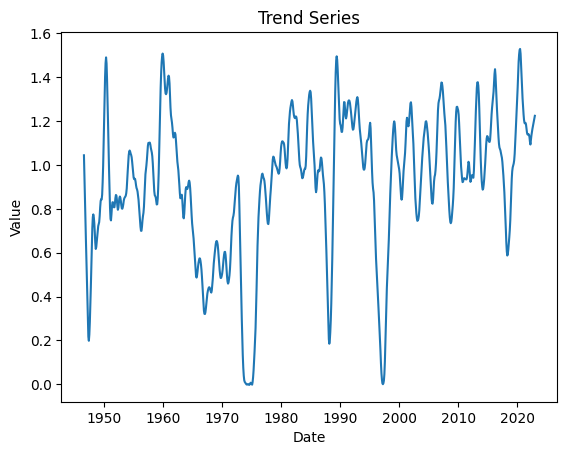

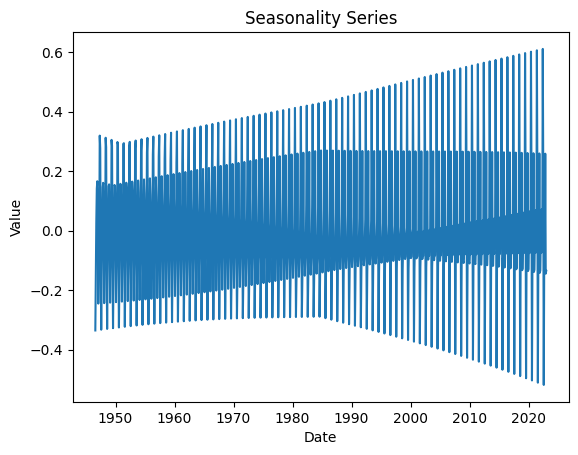

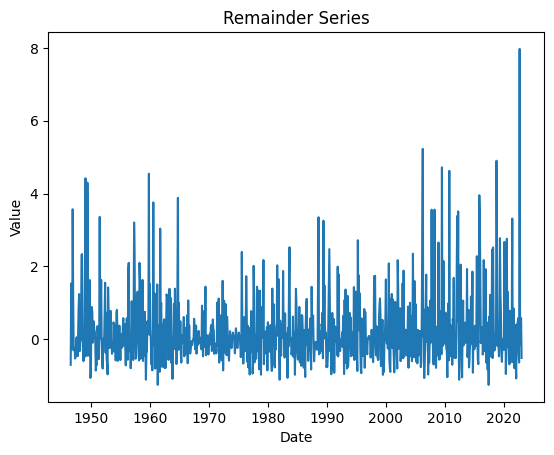

In [30]:
plt.plot(month_date_series, trend_series)
plt.title('Trend Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

plt.plot(month_date_series, seasonality_series)
plt.title('Seasonality Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

plt.plot(month_date_series, remainder_series)
plt.title('Remainder Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

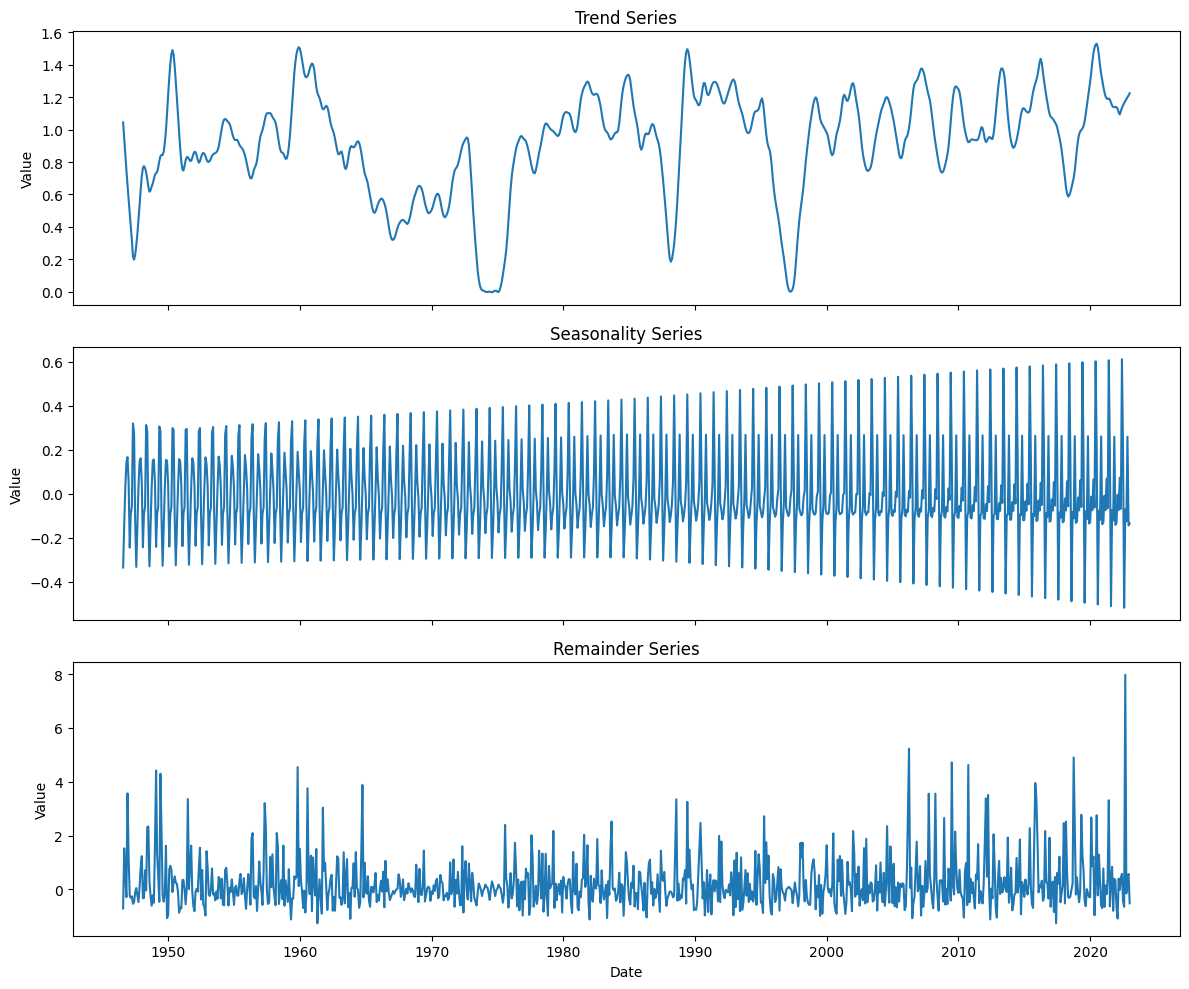

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Trend
axs[0].plot(month_date_series, trend_series)
axs[0].set_title('Trend Series')
axs[0].set_ylabel('Value')

# Seasonality
axs[1].plot(month_date_series, seasonality_series)
axs[1].set_title('Seasonality Series')
axs[1].set_ylabel('Value')

# Remainder
axs[2].plot(month_date_series, remainder_series)
axs[2].set_title('Remainder Series')
axs[2].set_ylabel('Value')
axs[2].set_xlabel('Date')

# Tight layout and save
plt.tight_layout()
plt.savefig("decomposition_series.png", dpi=300, bbox_inches='tight')
plt.show()

1. Compare the inferred seasonality with actual data

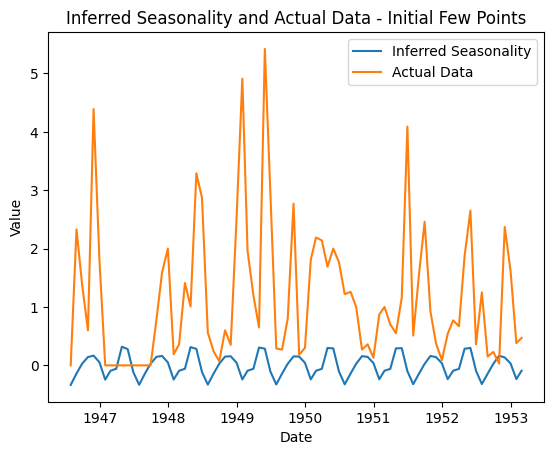

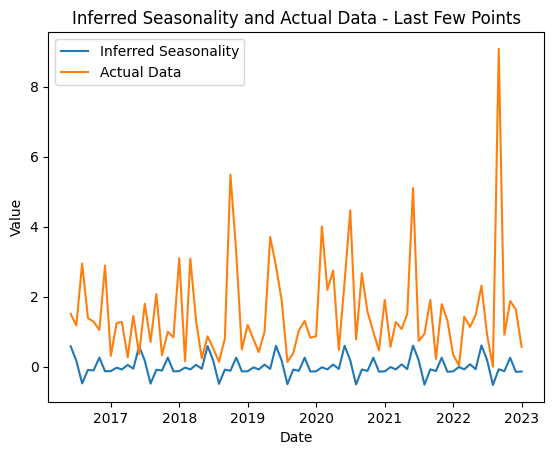

In [31]:
# Front Few Points
num_initial_points = 80

plt.plot(
    month_date_series[:num_initial_points],
    seasonality_series[:num_initial_points], 
    label='Inferred Seasonality'
)
plt.plot(
    month_date_series[:num_initial_points],
    month_max_series[:num_initial_points], 
    label='Actual Data'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Initial Few Points')
plt.show()

# Last Few Points
num_last_points = 80

plt.plot(
    month_date_series[-num_last_points:],
    seasonality_series[-num_last_points:], 
    label='Inferred Seasonality'
)
plt.plot(
    month_date_series[-num_last_points:],
    month_max_series[-num_last_points:], 
    label='Actual Data'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Last Few Points')
plt.show()


2. Parameter estimation of GEV fitted to remainder series

Fitting GEV parameters using PSO to remainder series

Shape Parameter: 0.11346310490618387 
Location Parameter: -0.2013988106347184 
Scale Parameter: 0.5697536499943279 
Log Likelihood: -841.5878482131293


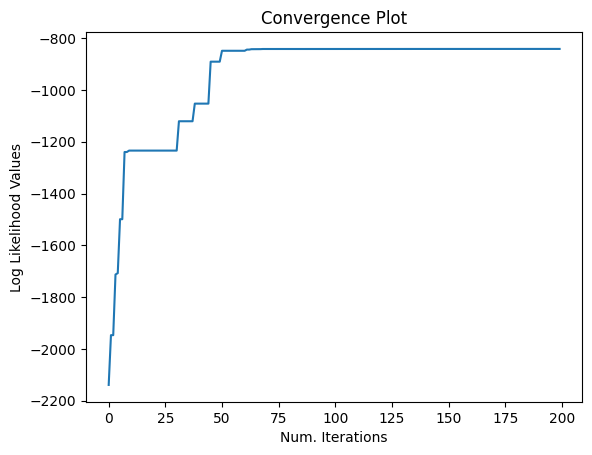

In [32]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    remainder_series[:num_train],
    Pso.computeInitialPos([(-10, 10), (-10, 10), (5, 30)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

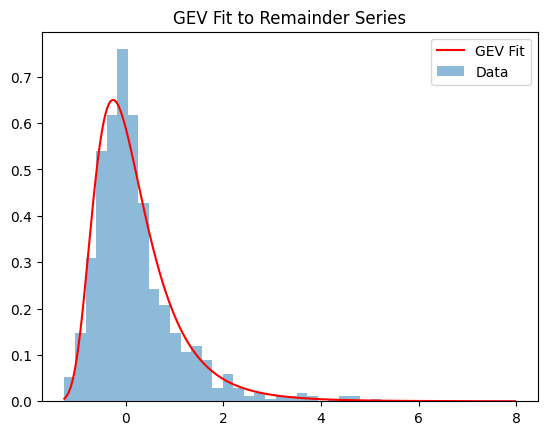

In [33]:
import scipy.stats as stats
import matplotlib.pyplot as plt

x = np.linspace(min(remainder_series), max(remainder_series), 1000)
gev_pdf = stats.genextreme.pdf(x, -shape, loc=location, scale=scale)  # scipy uses -ξ

plt.hist(remainder_series[:num_train], bins=30, density=True, alpha=0.5, label='Data')
plt.plot(x, gev_pdf, label='GEV Fit', color='red')
plt.legend()
plt.title("GEV Fit to Remainder Series")
plt.show()

In [34]:
gev_dist = GeneralizedExtremeValueDistribution(*tuple(params))

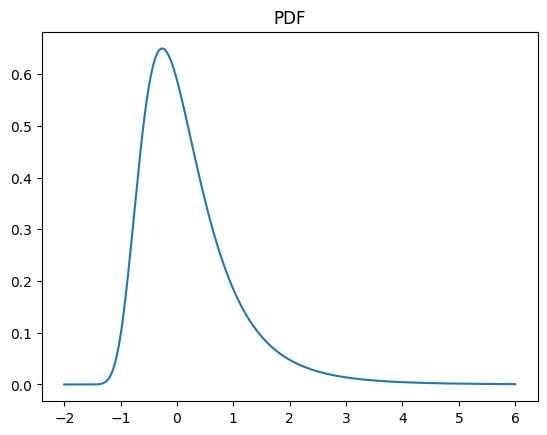

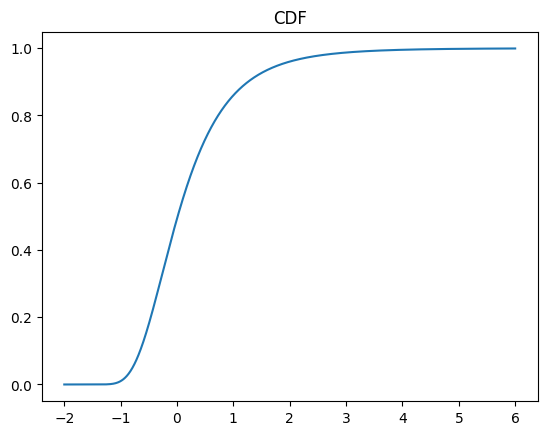

In [35]:
x = np.linspace(-2, 6, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

3. Compute CDF of each data point in remainder series

Data Type: float64, Data Shape: (918, 1)

First 5 data points:
array([[0.07733781],
       [0.92879782],
       [0.73169789],
       [0.30996226],
       [0.99282803]])

Last 5 data points:
array([[0.9997999 ],
       [0.40016971],
       [0.70027749],
       [0.75388708],
       [0.16860098]])


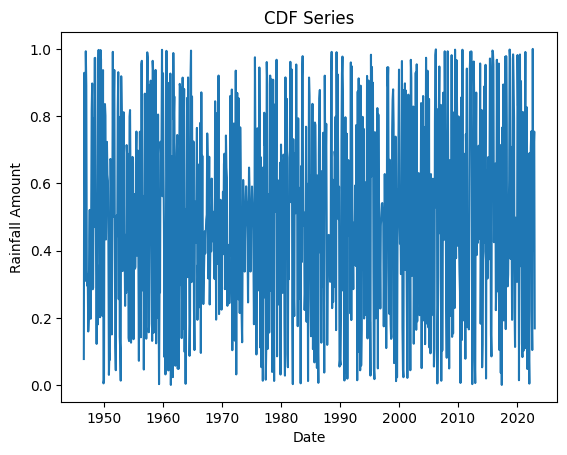

In [36]:
remainder_series_cdf = gev_dist.cdf(remainder_series)

print(f'Data Type: {remainder_series_cdf.dtype}, Data Shape: {remainder_series_cdf.shape}\n')
print('First 5 data points:')
pprint(remainder_series_cdf[:5])
print('')

print('Last 5 data points:')
pprint(remainder_series_cdf[-5:])

plt.plot(month_date_series, remainder_series_cdf)
plt.title('CDF Series')
plt.xlabel('Date')
plt.ylabel('Rainfall Amount')
plt.show()

In [144]:
# Set seed for reproducibility+
import os
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

4. Model for forecasting next day CDF

In [165]:
lag = 50

# # Tail-weighted loss function
# def tail_weighted_mse(y_true, y_pred):
#     weights = tf.abs(y_true - 0.5) * 2.0  # scale to range [0, 1]
#     return tf.reduce_mean(weights * tf.square(y_true - y_pred))

# def tail_weighted_mse(y_true, y_pred):
#     weights = tf.pow(tf.abs(y_true - 0.5) * 2.0, 2)  # Quadratic weight
#     return tf.reduce_mean(weights * tf.square(y_true - y_pred))

def tail_weighted_mse(y_true, y_pred):
    weights = tf.exp(tf.abs(y_true - 0.5) * 10)  # Adjust the scale factor
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))


model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, lag))
model.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    # loss=tf.losses.MeanSquaredError() original loss
    loss=tail_weighted_mse,
    #metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
)

In [166]:
input_data = []
output_data = []

for i in range(lag, num_train):
    input_data.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    output_data.append(remainder_series_cdf[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (730, 50)
Output Data Shape: (730, 1)


Epoch 1/200
23/23 [==============================] - 0s 750us/step - loss: 4.1994
Epoch 2/200
23/23 [==============================] - 0s 751us/step - loss: 4.0100
Epoch 3/200
23/23 [==============================] - 0s 745us/step - loss: 3.7474
Epoch 4/200
23/23 [==============================] - 0s 717us/step - loss: 3.8864
Epoch 5/200
23/23 [==============================] - 0s 662us/step - loss: 3.7160
Epoch 6/200
23/23 [==============================] - 0s 675us/step - loss: 3.5149
Epoch 7/200
23/23 [==============================] - 0s 749us/step - loss: 3.4700
Epoch 8/200
23/23 [==============================] - 0s 980us/step - loss: 3.2414
Epoch 9/200
23/23 [==============================] - 0s 525us/step - loss: 3.2978
Epoch 10/200
23/23 [==============================] - 0s 805us/step - loss: 3.1334
Epoch 11/200
23/23 [==============================] - 0s 858us/step - loss: 3.0086
Epoch 12/200
23/23 [==============================] - 0s 677us/step - loss: 2.9037
Epoch 13/200


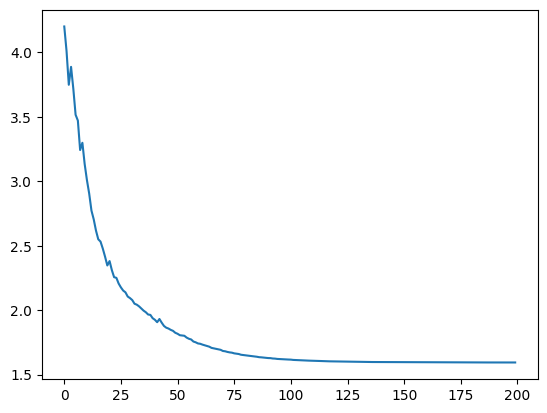

In [170]:
history = model.fit(input_data, output_data, epochs=200)
plt.plot(history.history['loss'])


5. Forecast training data

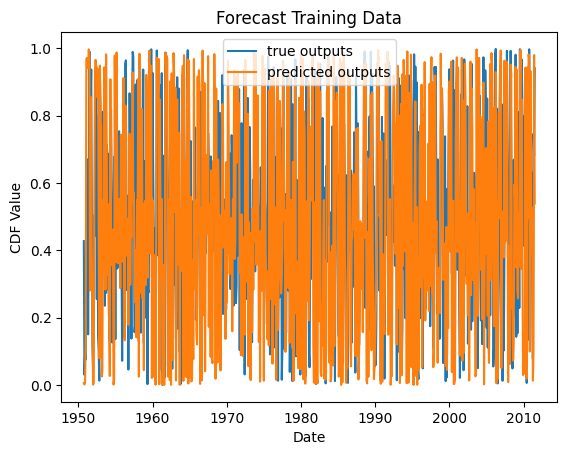

In [171]:
remainder_train_cdf = model.predict(input_data)
remainder_train = gev_dist.computeQuantile(remainder_train_cdf)

plt.plot(
    month_date_series[lag: num_train], 

    output_data, 
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train], 
    remainder_train_cdf, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('CDF Value')
plt.legend()
plt.title('Forecast Training Data')
plt.show()

5. Forecast training data

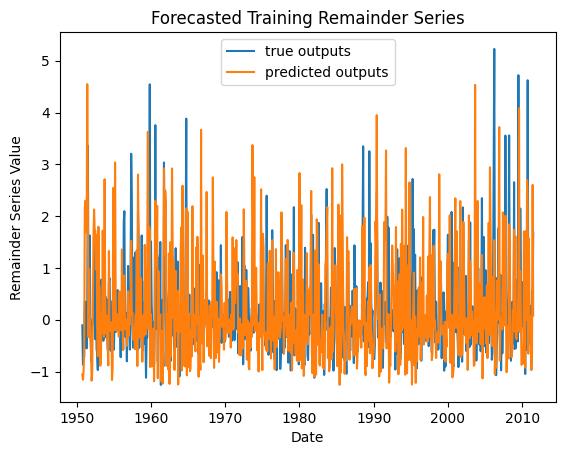

In [172]:
plt.plot(
    month_date_series[lag: num_train],
    remainder_series[lag: num_train],
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train], 
    remainder_train, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Remainder Series Value')
plt.legend()
plt.title('Forecasted Training Remainder Series')
plt.show()

6. Forecast test data

In [173]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    test_output.append(remainder_series_cdf[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (138, 50)
Test Output Data Shape: (138, 1)


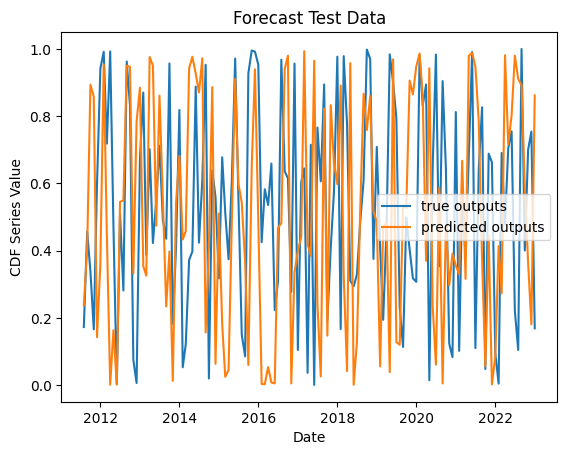

In [174]:
remainder_test_cdf = model.predict(test_input)
remainder_test = gev_dist.computeQuantile(remainder_test_cdf)

plt.plot(
    month_date_series[num_train:],
    test_output, 
    label='true outputs'
)
plt.plot(
    month_date_series[num_train:],
    remainder_test_cdf, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('CDF Series Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

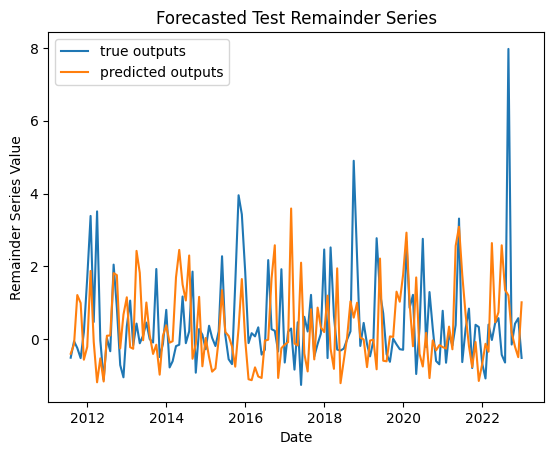

In [175]:
plt.plot(
    month_date_series[num_train:],
    remainder_series[num_train:], 
    label='true outputs'
)
plt.plot(
    month_date_series[num_train:],
    remainder_test, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Remainder Series Value')
plt.legend()
plt.title('Forecasted Test Remainder Series')
plt.show()

Forecasting Trend

In [176]:
lag = 50

model_trend = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation=None)
])

model_trend.build(input_shape=(None, lag))
model_trend.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

In [177]:
input_data = []
output_data = []

for i in range(lag, num_train):
    input_data.append(np.squeeze(trend_series[i - lag:i], axis=1))
    output_data.append(trend_series[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (730, 50)
Output Data Shape: (730, 1)


Epoch 1/100
23/23 [==============================] - 0s 710us/step - loss: 0.1536
Epoch 2/100
23/23 [==============================] - 0s 710us/step - loss: 0.0349
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 4/100
23/23 [==============================] - 0s 734us/step - loss: 0.0097
Epoch 5/100
23/23 [==============================] - 0s 614us/step - loss: 0.0075
Epoch 6/100
23/23 [==============================] - 0s 693us/step - loss: 0.0062
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 8/100
23/23 [==============================] - 0s 682us/step - loss: 0.0050
Epoch 9/100
23/23 [==============================] - 0s 728us/step - loss: 0.0069
Epoch 10/100
23/23 [==============================] - 0s 588us/step - loss: 0.0045
Epoch 11/100
23/23 [==============================] - 0s 696us/step - loss: 0.0055
Epoch 12/100
23/23 [==============================] - 0s 867us/step - loss: 0.0044
Epoch 13/100
23/2

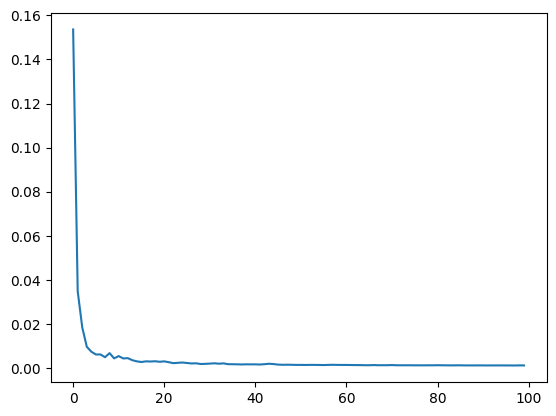

In [178]:
history = model_trend.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

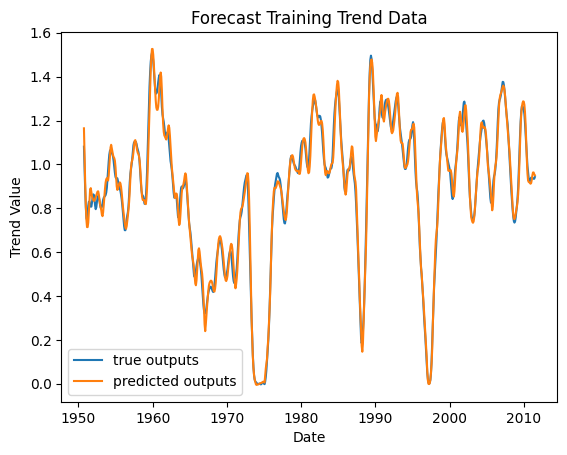

In [179]:
trend_train = model_trend.predict(input_data)

plt.plot(
    month_date_series[lag: num_train],
    output_data, 
    label='true outputs'
)
plt.plot(
    month_date_series[lag: num_train],
    trend_train, 
    label='predicted outputs'
)
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.title('Forecast Training Trend Data')
plt.show()

7. Forecast test data

In [180]:
test_input = []
test_output = []

for i in range(num_train, n):
    test_input.append(np.squeeze(trend_series[i - lag:i], axis=1))
    test_output.append(trend_series[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (138, 50)
Test Output Data Shape: (138, 1)


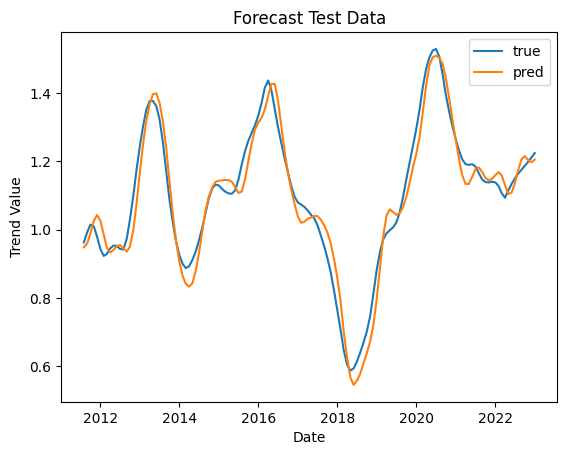

In [181]:
trend_test = model_trend.predict(test_input)

plt.plot(
    month_date_series[num_train:], 
    test_output, 
    label='true'
)
plt.plot(
    month_date_series[num_train:], 
    trend_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

8. Forecast seasonality

In [182]:
seasonality_train = seasonality_series[:num_train][lag:]

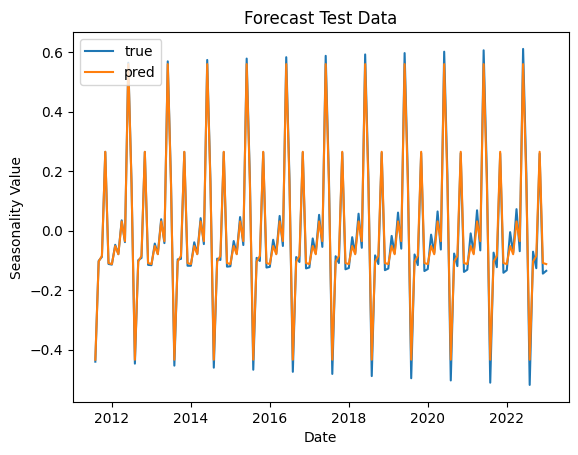

In [183]:
season_values = seasonality_series[:num_train][-12:]
seasonality_test = np.zeros((n - num_train, 1))

for i in range(n - num_train):
    seasonality_test[i] = season_values[i % 12]
    
plt.plot(
    month_date_series[num_train:],
    seasonality_series[num_train:], 
    label='true'
)
plt.plot(
    month_date_series[num_train:],
    seasonality_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Seasonality Value')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

9. Forecast maximum rainfall

In [184]:

print(remainder_train.shape, trend_train.shape, seasonality_train.shape)
print(remainder_test.shape, trend_test.shape, seasonality_test.shape)

(730, 1) (730, 1) (730, 1)
(138, 1) (138, 1) (138, 1)


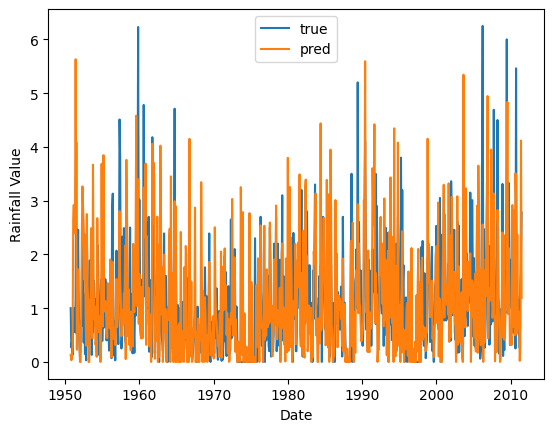

In [185]:
pred_train = np.maximum(remainder_train + trend_train + seasonality_train, 0)
true_train = month_max_series[:num_train][lag:]

plt.plot(
    month_date_series[lag: num_train],
    true_train, 
    label='true'
)
plt.plot(
    month_date_series[lag: num_train],
    pred_train, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.legend()
plt.show()

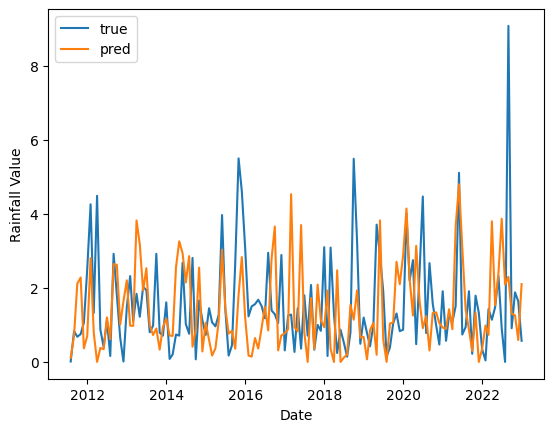

In [186]:
pred_test = np.maximum(remainder_test + trend_test + seasonality_test, 0)
true_test = month_max_series[num_train:]

plt.plot(
    month_date_series[num_train:],
    true_test, 
    label='true'
)
plt.plot(
    month_date_series[num_train:],
    pred_test, 
    label='pred'
)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.legend()
plt.show()

In [187]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 1: Choose a high quantile threshold (e.g., 95th percentile of the true values)
# threshold = np.percentile(true_test, 70)
threshold = 2
# Step 2: Create binary labels
true_extreme = (true_test >= threshold).astype(int)
pred_extreme = (pred_test >= threshold).astype(int)

# Step 3: Compute classification metrics
precision = precision_score(true_extreme, pred_extreme)
recall = recall_score(true_extreme, pred_extreme)
f1 = f1_score(true_extreme, pred_extreme)

# Step 4: Print the results
print(f"POT Threshold (95th percentile): {threshold:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

POT Threshold (95th percentile): 2.00
Precision: 0.28
Recall: 0.34
F1-score: 0.31
